## Computer Vision Assignments #4
#### By Kiarash Parvizi

Import needed libraries

In [503]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Initial setup + Utils

In [504]:
# Make our images bigger.
plt.rcParams['figure.figsize'] = (7.4, 7.4)

def print_basic_img_stats(img):
    print('basic_img_stats:')
    print(img.shape)
    print(img.dtype)
    print('avg:',np.average(img))
    print('min:',np.min(img))
    print('max:',np.max(img))
    print('-'*20)

### Problem 1
In this problem you will use your image processing knowledge to repair a
corrupted image. Remove the lines from the corrupted "f.png" image.

#### Read and Display the image:

basic_img_stats:
(510, 511, 3)
float32
avg: 0.39575937
min: 0.0
max: 1.0
--------------------


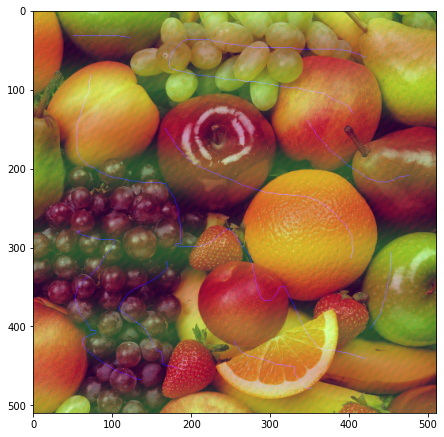

In [505]:
# read the image
img = plt.imread('f.png')
print_basic_img_stats(img)

# display
plt.imshow(img, 'gray')

#### Break the image into three channels (RGB):

In [506]:
rimg = img[:,:,0]
gimg = img[:,:,1]
bimg = img[:,:,2]

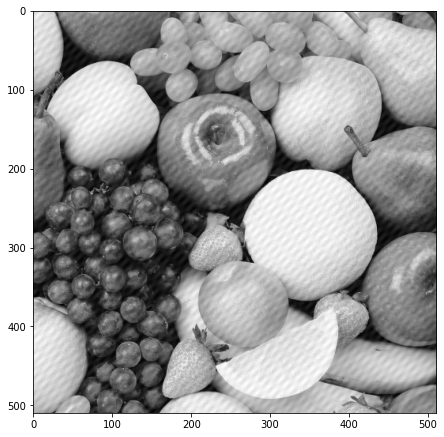

In [507]:
plt.imshow(rimg, 'gray')

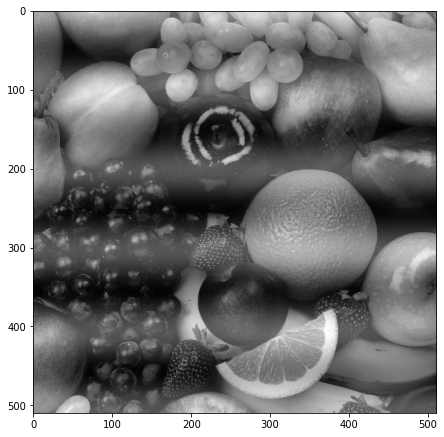

In [508]:
plt.imshow(gimg, 'gray')

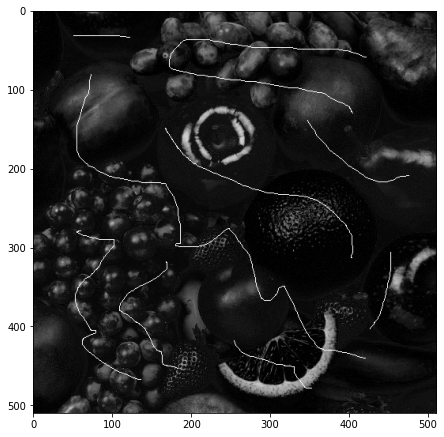

In [509]:
plt.imshow(bimg, 'gray')

#### remove blue lines from the blue channel of the image:
For this purpose, the DFS algorithm would be the perfect choice.<br/>
The average filter will also be used. note that we don't count the pixels of the lines when taking the average

white line detected
white line detected
white line detected
white line detected
white line detected
white line detected
white line detected
white line detected
white line detected


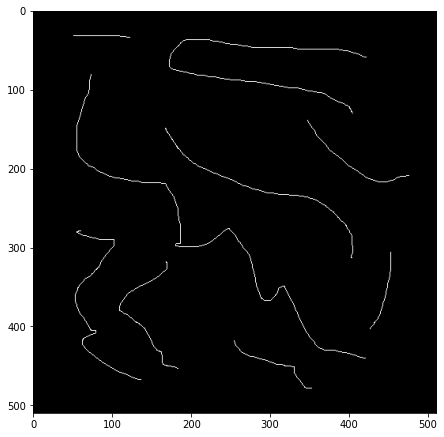

In [510]:
threshold = 30 # minimum size of line to be detected
AvgKernel_Width = 7
HW = AvgKernel_Width // 2

# vised table: used for remembering which pixels are already processed by dfs
vised = set({})

def dfs(si,sj: int):
    st = [(si,sj)]
    ls = []
    while len(st) != 0:
        t = st[-1]
        x,y = t
        st = st[:-1]
        ls.append(t)
        # expand
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x+dx, y+dy
                if nx < 0 or nx >= bimg.shape[0]:
                    continue
                if ny < 0 or ny >= bimg.shape[1]:
                    continue
                if nx == 0 and ny == 0:
                    continue
                if (nx,ny) in vised:
                    continue
                if bimg[nx,ny] != bimg[x,y]:
                    continue
                st.append((nx,ny))
                vised.add((nx,ny))
    return ls
    
def areaAvg(si,sj: int, excludeVal: int) -> int:
    su, cnt = 0, 0
    for i in range(max(0,si-HW), min(bimg.shape[0],si+HW+1)):
        for j in range(max(0,sj-HW), min(bimg.shape[1],sj+HW+1)):
            if bimg[i,j] == excludeVal: continue
            su += bimg[i,j]
            cnt += 1
    return su / cnt

changeImg = np.zeros(bimg.shape)
    
def replace_with_avg(ls):
    for t in ls:
        changeImg[t[0],t[1]] = 255
        bimg[t[0],t[1]] = areaAvg(t[0],t[1], bimg[t[0],t[1]])

for i in range(bimg.shape[0]):
    for j in range(bimg.shape[1]):
        if bimg[i,j] < 0.5:
            # too dark
            continue
        if (i,j) in vised:
            continue
        ls = dfs(i,j)
        if len(ls) > threshold:
            print('white line detected')
            replace_with_avg(ls)

# show changed areas:
plt.imshow(changeImg, 'gray')

#### Render the resulting image:

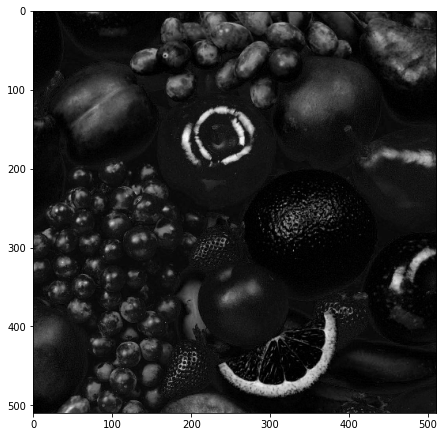

In [511]:
plt.imshow(bimg, 'gray')

#### take fft2 of each channel

In [512]:
# take fft2
rf = np.fft.fft2(rimg)
gf = np.fft.fft2(gimg)
bf = np.fft.fft2(bimg)
print_basic_img_stats(rimg)
# fft-shift
rfshift = np.fft.fftshift(rf)
gfshift = np.fft.fftshift(gf)
bfshift = np.fft.fftshift(bf)

# take log and multiply by a constant
rlT_img = 14*np.log(np.abs(1 + rfshift))
glT_img = 14*np.log(np.abs(1 + gfshift))
blT_img = 14*np.log(np.abs(1 + bfshift))

basic_img_stats:
(510, 511)
float32
avg: 0.5626508
min: 0.11764706
max: 0.8862745
--------------------


#### display the log transformed image

#### Red channel:

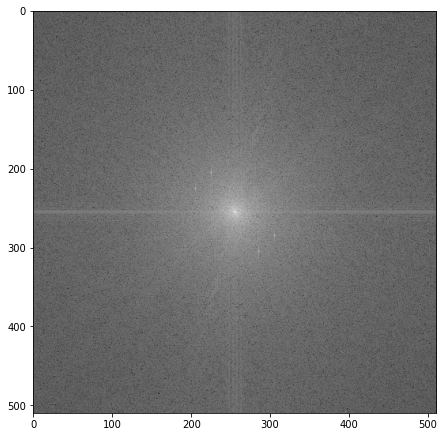

In [513]:
plt.imshow(rlT_img, 'gray')

#### Green channel:

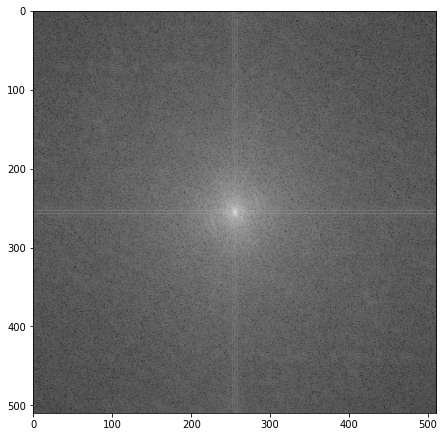

In [514]:
plt.imshow(glT_img, 'gray')

#### Blue channel:

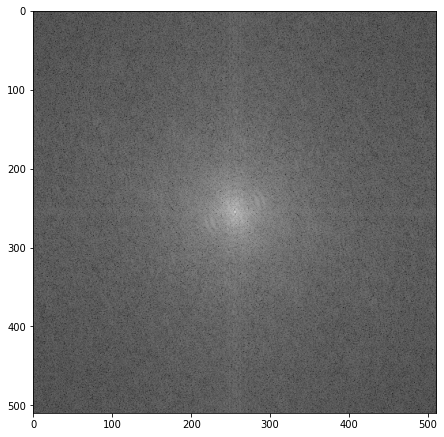

In [515]:
plt.imshow(blT_img, 'gray')

#### Red channel correction in frequency domain:
for this we filter out the unwanted points in frequency domain

#### Algorithm for finding center points of star shapes in freq image:

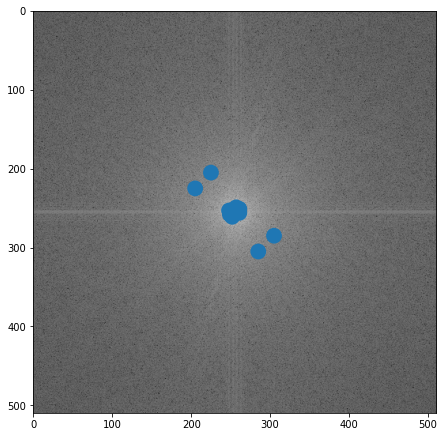

In [516]:
from matplotlib.patches import Circle

tmp = rlT_img.copy()
thresh = np.max(tmp)*0.64

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(tmp, 'gray')

fCircleLocations = []

def run_algo():
    def dfs(si, sj):
        if tmp[si,sj] < thresh:
            return -1,-1
        suX, suY = 0, 0
        cntX, cntY = 0, 0
        tmp[si,sj] = 0
        st = [(si,sj)]
        while len(st) != 0:
            x, y = st[-1]
            st = st[:-1]
            suX += x
            suY += y
            cntX += 1
            cntY += 1
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    nx, ny = dx + x, dy + y
                    if nx < 0 or ny < 0 or nx >= tmp.shape[0] or ny >= tmp.shape[1]: continue
                    if tmp[nx,ny] >= thresh:
                        st.append((nx,ny))
                        tmp[nx,ny] = 0
        #return si, sj
        return suX//cntX, suY//cntY
    for i in range(tmp.shape[0]):
        for j in range(tmp.shape[1]):
            x, y = dfs(i, j)
            if x == -1:
                continue
            circ = Circle((y,x),10)
            #print(x,y)
            fCircleLocations.append((x,y))
            ax.add_patch(circ)
run_algo()

# Show the image
plt.show()

#### Remove extra-noise locations:

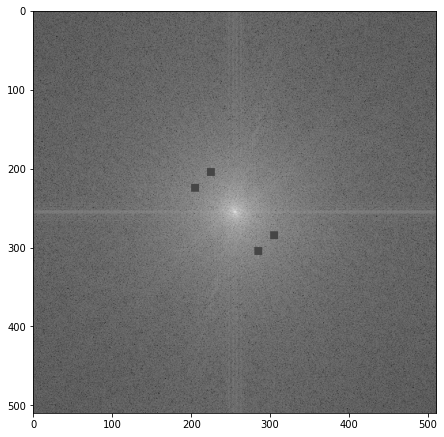

In [517]:
rfshiftTmp = rfshift.copy()
r = 5
R = 20
noiseComp = rfshiftTmp.copy()
noiseComp.fill(0+0j)

for circlePos in fCircleLocations:
    x, y = circlePos
    if abs(rfshiftTmp.shape[0]//2 - x) < R and abs(rfshiftTmp.shape[1]//2 - y) < R:
        continue
    for i in range(max(0, x-r), min(rfshiftTmp.shape[0], x+r)):
        for j in range(max(0, y-r), min(rfshiftTmp.shape[1], y+r)):
            noiseComp[i,j] = rfshiftTmp[i,j]
            rfshiftTmp[i,j] = 0+0j

# show the resulting freq image
plt.imshow(24*np.log(np.abs(1+rfshiftTmp)), 'gray')

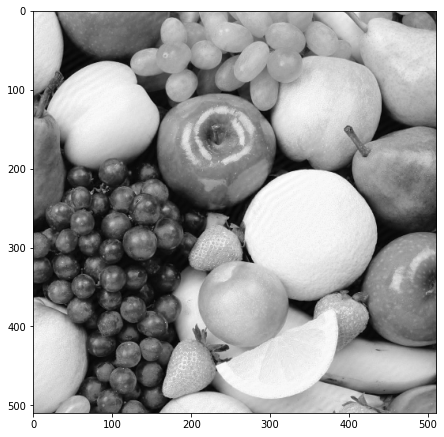

In [518]:
rG = np.fft.ifftshift(rfshiftTmp)
output = np.abs(np.fft.ifft2(rG))
plt.imshow(output, 'gray')

As can be seen in the above image, the noise is completely gone :)
Let's now render the noise that was removed:

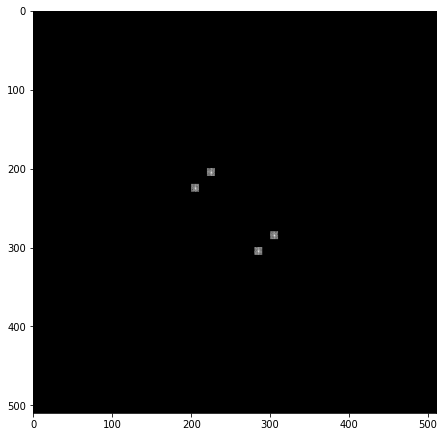

In [519]:
# show the resulting freq image
plt.imshow(24*np.log(np.abs(1+noiseComp)), 'gray')

#### Green channel correction in frequency domain:
for this we filter out the unwanted points in frequency domain

#### Algorithm for finding center points of star shapes in freq image:

250 255
255 255
260 255


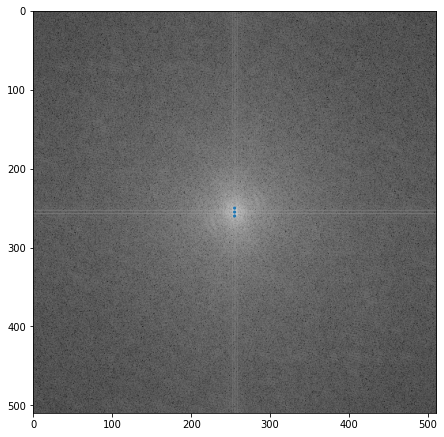

In [520]:
from matplotlib.patches import Circle

tmp = glT_img.copy()
thresh = np.max(tmp)*0.8

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(tmp, 'gray')

fCircleLocations = []

def run_algo():
    def dfs(si, sj):
        if tmp[si,sj] < thresh:
            return -1,-1
        suX, suY = 0, 0
        cntX, cntY = 0, 0
        tmp[si,sj] = 0
        st = [(si,sj)]
        while len(st) != 0:
            x, y = st[-1]
            st = st[:-1]
            suX += x
            suY += y
            cntX += 1
            cntY += 1
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    nx, ny = dx + x, dy + y
                    if nx < 0 or ny < 0 or nx >= tmp.shape[0] or ny >= tmp.shape[1]: continue
                    if tmp[nx,ny] >= thresh:
                        st.append((nx,ny))
                        tmp[nx,ny] = 0
        #return si, sj
        return suX//cntX, suY//cntY
    for i in range(tmp.shape[0]):
        for j in range(tmp.shape[1]):
            x, y = dfs(i, j)
            if x == -1:
                continue
            circ = Circle((y,x),2)
            print(x,y)
            fCircleLocations.append((x,y))
            ax.add_patch(circ)
run_algo()

# Show the image
plt.show()

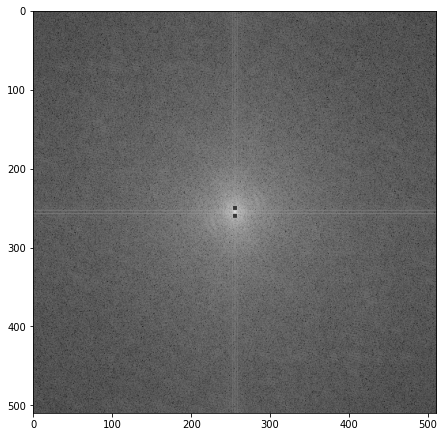

In [521]:
gfshiftTmp = gfshift.copy()
rx,ry = 2,2
R = 2
noiseComp = gfshiftTmp.copy()
noiseComp.fill(0+0j)

for circlePos in fCircleLocations:
    x, y = circlePos
    if abs(gfshiftTmp.shape[0]//2 - x) < R and abs(gfshiftTmp.shape[1]//2 - y) < R:
        continue
    for i in range(max(0, x-rx), min(gfshiftTmp.shape[0], x+rx+1)):
        for j in range(max(0, y-ry), min(gfshiftTmp.shape[1], y+ry+1)):
            noiseComp[i,j] = gfshiftTmp[i,j]
            gfshiftTmp[i,j] = 0+0j

# show the resulting freq image
plt.imshow(24*np.log(np.abs(1+gfshiftTmp)), 'gray')

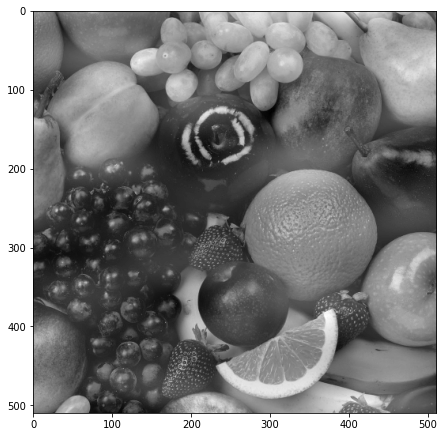

In [522]:
gG = np.fft.ifftshift(gfshiftTmp)
output = np.abs(np.fft.ifft2(gG))
plt.imshow(output, 'gray')

By doing so, the image quality has gotten better, but some of the data is also lost.<br/>
Fortunately the amount of data lost is minor, and the overall quality of the image has gotten better and more pleasing to the human eye :)

#### Combine the three channels (RGB) back into a single colored image:

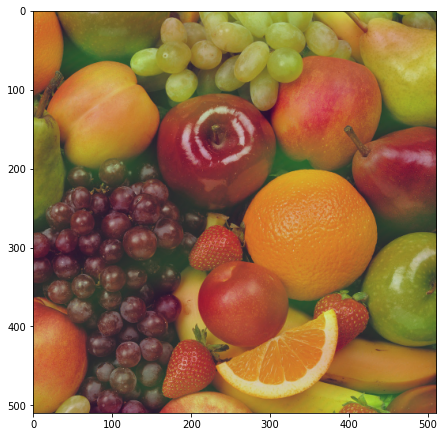

In [523]:
# the three enhanced channels are:
# rG, gG, bimg

resImg = img

resImg[:,:,0] = np.abs(np.fft.ifft2(rG))
resImg[:,:,1] = np.abs(np.fft.ifft2(gG))
resImg[:,:,2] = bimg

plt.imshow(resImg)


In the resulting image, all the painted lines and extra noise of all types are removed, resulting in a much better image

### Problem 2
Apply histogram equalization to tune the low exposure image named as
"badexposure.jpg".<br/>
Show the histograms before and after applying the histogram equalization
algorithm.

#### Read and Display the image:

basic_img_stats:
(288, 432, 3)
uint8
avg: 92.9432602451989
min: 0
max: 246
--------------------


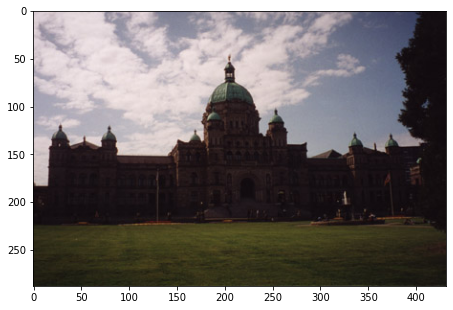

In [524]:
# read the image
img = plt.imread('badexposure.jpg')
print_basic_img_stats(img)

# display
plt.imshow(img, 'gray')

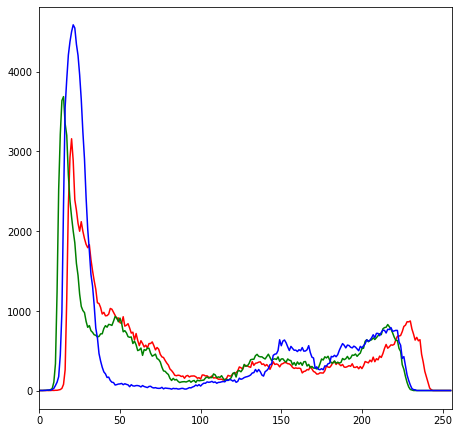

In [525]:
for i, col in enumerate(['r', 'g', 'b']):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.xlim([0, 256])
    
plt.show()

#### Convert the image to HSV format and draw the histogram:

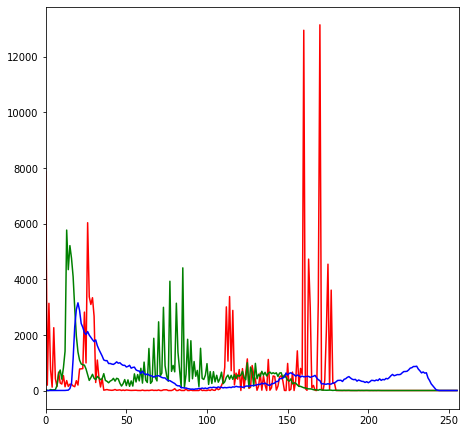

In [526]:
himg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# blue represents the v in HSV
for i, col in enumerate(['r', 'g', 'b']):
    hist = cv2.calcHist([himg], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.xlim([0, 256])
    
plt.show()

#### Run Histogram Equalization algorithm on V channel:

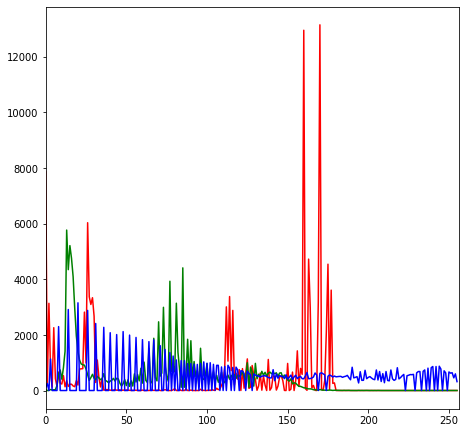

In [527]:
himg[:,:,2] = cv2.equalizeHist(himg[:,:,2])

# show histogram
# blue represents the v in HSV
for i, col in enumerate(['r', 'g', 'b']):
    hist = cv2.calcHist([himg], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.xlim([0, 256])
    
plt.show()

#### Convert the HSV image back to RGB and render:

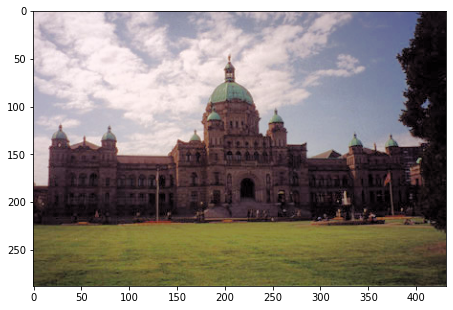

In [528]:
resImg = cv2.cvtColor(himg, cv2.COLOR_HSV2RGB)

plt.imshow(resImg)

The resulting image looks a lot better

### Problem 3
- 1) Remove the noise from the image Q4-1.tif.
- 2) Seperate the two types of blobs in the Q4-4.tif.

#### Read and Display the image:

basic_img_stats:
(566, 566)
uint8
avg: 66.87986802182571
min: 0
max: 253
--------------------


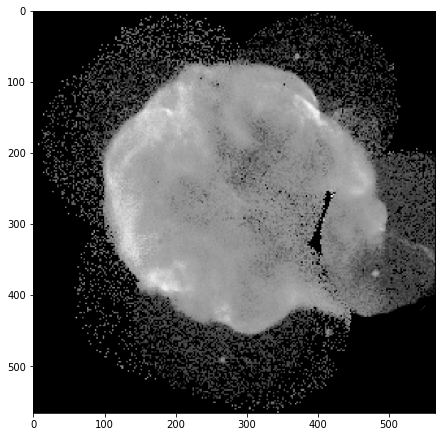

In [529]:
# read the image
img = plt.imread('Q4_1.tif')
print_basic_img_stats(img)

# display
plt.imshow(img, 'gray')

We first binarize the image and run opening operation on it. After that we can use the resulting image as a mask for the original image

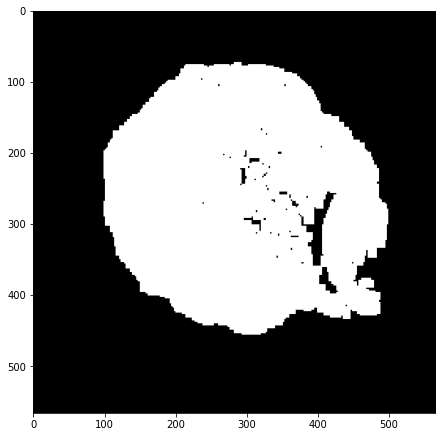

In [530]:
# binarize the image
binr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# define the kernel
kernel = np.ones((10, 10), np.uint8)
# opening the image
opening = cv2.morphologyEx(binr, cv2.MORPH_OPEN, kernel, iterations=1)
# print the output
plt.imshow(opening, cmap='gray')

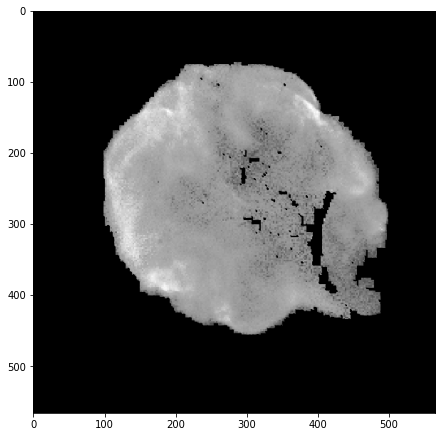

In [531]:
masked = cv2.bitwise_and(img, img, mask=opening)

# render the resulting image
plt.imshow(masked, cmap='gray')

Additionally we can run the median filter on the masked image

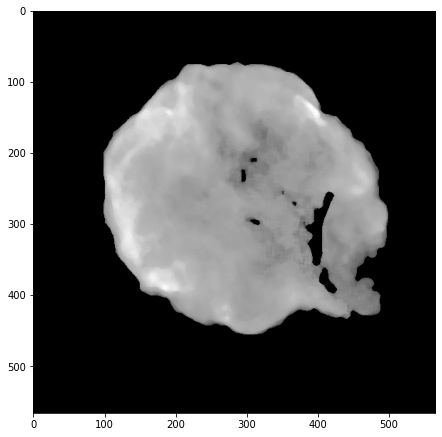

In [532]:
finImg = cv2.medianBlur(masked, 9)

# render the resulting image
plt.imshow(finImg, cmap='gray')

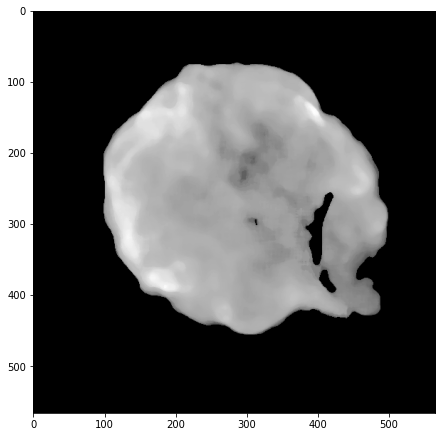

In [533]:
finImg = cv2.medianBlur(masked, 13)

# render the resulting image
plt.imshow(finImg, cmap='gray')

### part2: Seperate the two types of blobs in the Q4-4.tif

#### Read and Display the image:

basic_img_stats:
(600, 600)
uint8
avg: 153.57426666666666
min: 76
max: 255
--------------------


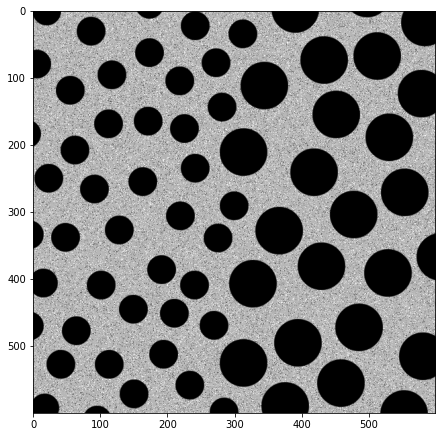

In [534]:
# read the image
img = plt.imread('Q4_4.tif')
print_basic_img_stats(img)

# display
plt.imshow(img, 'gray')

Binarize and run opening operation on the image:

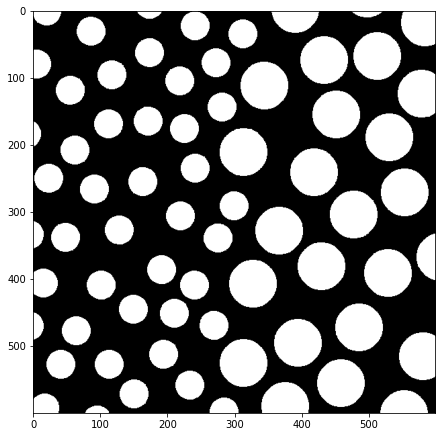

In [535]:
# Threshold it so it becomes binary
binr = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# define the kernel
kernel = np.ones((3, 3), np.uint8)

# invert the image
invert = cv2.bitwise_not(binr)

# give some padding to the image
#invert = np.pad(invert, [50, 50], mode='constant')

# opening the image
opening0 = cv2.morphologyEx(invert, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(opening0,'gray')

find all Contours:

In [536]:
cont_img = opening0.copy()

contours, hierarchy = cv2.findContours(cont_img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

print("number of circles: ",len(contours))

number of circles:  69


Apply eriosion operation large kernel size so that the smaller blobs are removed:

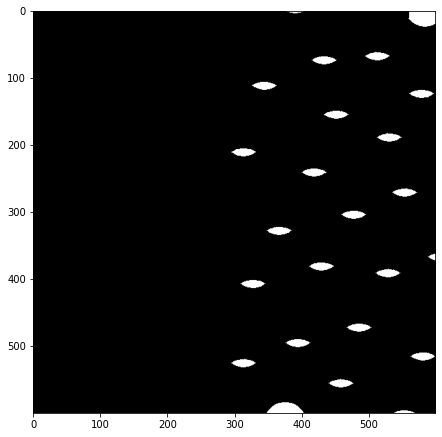

In [537]:
# define the kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,60))

# apply erosion
erosion = cv2.erode(invert, kernel, iterations=1)

# render
plt.imshow(erosion,'gray')

subtract the eroded image from the original one (this is just for representation).<br/>
All large circles are shown by rendering a dark spot inside of them

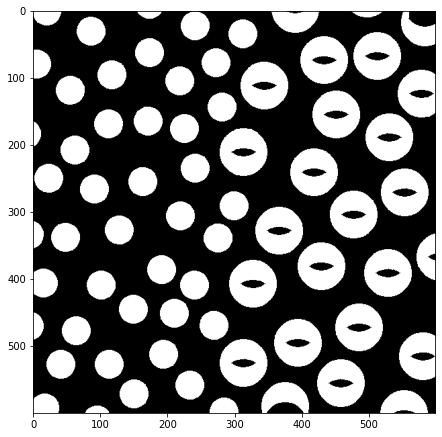

In [538]:
subImg = opening0 - erosion

# render
plt.imshow(subImg, 'gray')

Now we can easily detect circles of each category:<br/>
if a circle has any intersection with any object in the erosion image, then it's a large one, otherwise it's small.

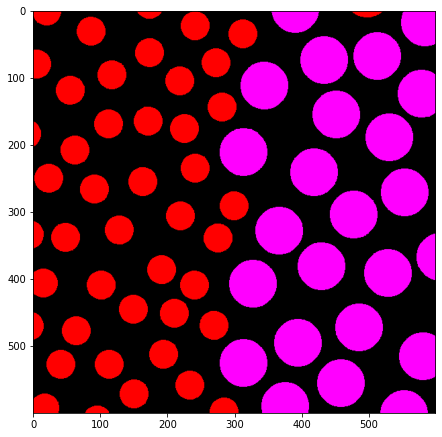

In [539]:
# colored image for showing the result
cImg = np.zeros((opening0.shape[0], opening0.shape[1], 3), np.uint8)
for i in range(opening0.shape[0]):
    for j in range(opening0.shape[1]):
        if opening0[i,j] != 0:
            cImg[i,j][0] = 255

def dfs_fill(si,sj: int):
    if cImg[si,sj,2] == 255: return
    cImg[si,sj,2] = 255
    st = [(si,sj)]
    while len(st) != 0:
        t = st[-1]
        x,y = t
        st = st[:-1]
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx,ny = x+dx, y+dy
                if nx < 0 or ny < 0: continue
                if nx >= cImg.shape[0]: continue
                if ny >= cImg.shape[1]: continue
                if opening0[nx,ny] == 0: continue
                if cImg[nx,ny,2] == 255: continue
                cImg[nx,ny,2] = 255
                st.append((nx,ny))

for i in range(cImg.shape[0]):
    for j in range(cImg.shape[1]):
        if erosion[i,j] != 0:
            dfs_fill(i,j)

plt.imshow(cImg)

### Problem 4

The image (Q4-3.tif) includes objects of rice grains of different orientations over a dark background. In this problem, you are asked to develop a program to
- (a) Detect (extract from background) the rice grain objects (By example using theresholding)
- (b) Compute the number and average size of the rice grains.<br/>

(Use the morphological operations to count the number of rice grains such as Opening, Closing connected components and ...)

#### Read and Display the image:

basic_img_stats:
(600, 600)
uint8
avg: 116.4138
min: 47
max: 243
--------------------


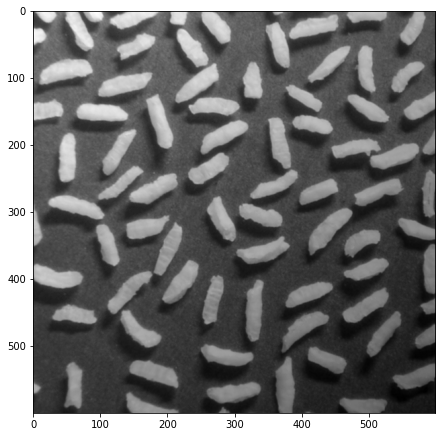

In [540]:
# read the image
img = plt.imread('Q4_3.tif')
print_basic_img_stats(img)

# display
plt.imshow(img, 'gray')

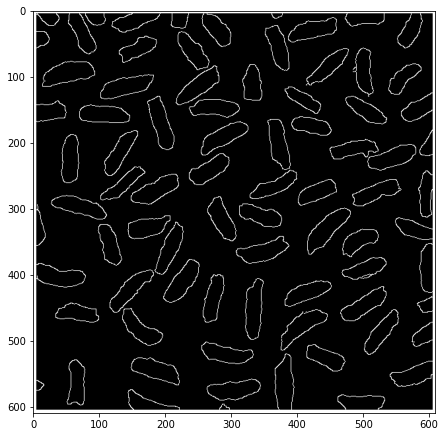

In [541]:
# Detect edges in the image using Canny edge detection algorithm 
edges = cv2.Canny(img, 100, 200) 

# give one padding to the image
canvas = np.full((edges.shape[0]+10,edges.shape[1]+10), 255, dtype=np.uint8)
canvas[5:5+edges.shape[0],5:5+edges.shape[1]] = edges

# threshold
thresh = cv2.threshold(canvas, 128, 255, cv2.THRESH_BINARY)[1]
#thresh = cv2.GaussianBlur(thresh,(5,5),1)
#thresh = cv2.threshold(thresh, 20, 255, cv2.THRESH_BINARY)[1]

plt.imshow(thresh, 'gray')

number of contours in the image:  136
rice count:  81
average rice area:  1228.0246913580247 (pixel)
** note that average rice area is in pixels
percentage of the image occupied by rice:  26.732061273851116 %


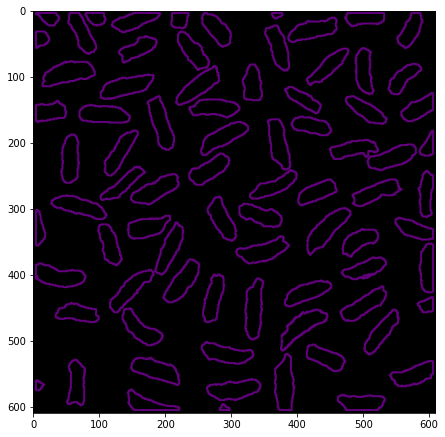

In [542]:
tmp = thresh.copy()

# find contours in the canny filtered image  
contours, hierarchy = cv2.findContours(tmp,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

# draw contours on the original image  
#tmp = cv2.drawContours(tmp, contours[:22],-1 , 255, 2)  

colImg = np.zeros((tmp.shape[0],tmp.shape[1],3), np.int8)

print('number of contours in the image: ', len(contours))

innerContours = []

objCnt = 0
sumArea = 0
for i, h in enumerate(hierarchy[0]):
    if h[2] == -1:
        innerContours.append(contours[i])
        objCnt += 1
        sumArea += cv2.contourArea(contours[i])
        
avgArea = sumArea / objCnt

# draw contours on the colored image  
colImg = cv2.drawContours(colImg, innerContours,-1 , (100,0,200), 2)  
plt.imshow(colImg, 'gray')

print('rice count: ', objCnt)
print('average rice area: ', avgArea, '(pixel)')
print('** note that average rice area is in pixels')
print('percentage of the image occupied by rice: ', 100 * sumArea / (colImg.shape[0]*colImg.shape[1]), '%')